<a href="https://colab.research.google.com/github/lightsoutzy/Deep-Learning-Final-Project/blob/main/MMAI_891_NLP_Dufferin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Vaccinate or Not to Vaccinate: It’s not a Question





# 1) Environment Setup



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten

from google.colab import files

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

#from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

import string
import re
!pip install -q transformers tfds-nightly
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from keras.callbacks import EarlyStopping
from transformers import TFRobertaModel, AutoTokenizer, AutoModel, TFBertModel, BertTokenizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

!pip install nlpaug
import nlpaug.augmenter.word as naw
import random

!pip install pyspellchecker
from spellchecker import SpellChecker
!pip install contractions
import contractions

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
!pip install simpletransformers

from simpletransformers.classification.classification_model import ClassificationModel
from sklearn.metrics import mean_squared_error as mse

import os

!pip install --upgrade datasets
import datasets



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2)  Load data

In [2]:
tf.random.set_seed(42)

# Load the data from Google Drive
train_url = 'https://drive.google.com/file/d/1gdIp_t60901hF-zJMKYpEdQ9ViVPgAbF/view?usp=drivesdk'
train_path = 'https://drive.google.com/uc?export=download&id='+train_url.split('/')[-2]
train = pd.read_csv(train_path)
train['label'][~train['label'].isin([0, -1, 1])] = -1 #Converting invalid label values to -1
train = train.dropna()

train_ds = train.loc[:, ["tweet_id", "safe_text", "label", "agreement"]] #Extract label fields from Train dataset

train_ds["label"] = train_ds["label"].astype('int')
#train_ds['label'] = train_ds['label'] +1 #Increment 'label' column of 'train_ds' by 1
#train_ds['label'] = train_ds['label'] * train_ds['agreement'] #Combine Agreement and Label

train_ds["label"] = train_ds["label"].astype('category')

test_url = 'https://drive.google.com/file/d/1GcWTNFdzZnooZIot6Or1qZC2EDIR7njt/view?usp=drivesdk'
test_path = 'https://drive.google.com/uc?export=download&id='+test_url.split('/')[-2]
test_ds = pd.read_csv(test_path) # Read in test

test_ds['safe_text'] = test_ds['safe_text'].fillna('xxxx')

print (train_ds.shape)
print (test_ds.shape)
train_ds['label'].value_counts()

(9999, 4)
(5177, 2)


,count
label,
0,4908
1,4053
-1,1038


# 3) Data Exploration

In [3]:
test_ds.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


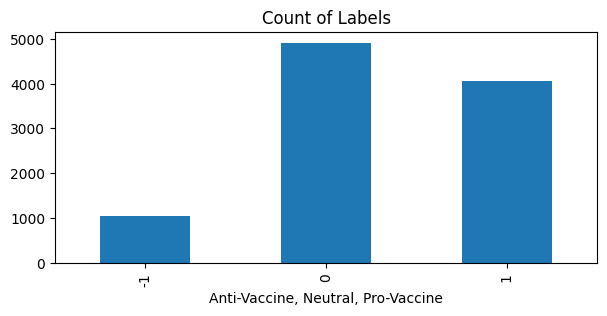

In [ ]:
ax = train_ds['label'].value_counts().sort_index().plot(kind='bar', title='Count of Labels', figsize=(7,3), )
ax.set_xlabel('Anti-Vaccine, Neutral, Pro-Vaccine')
plt.show()

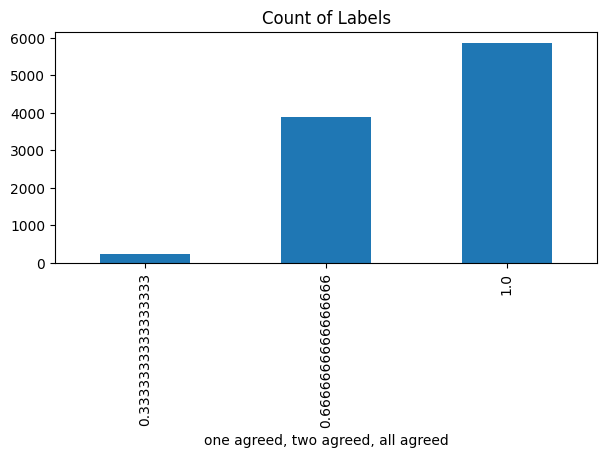

In [ ]:
ax = train_ds['agreement'].value_counts().sort_index().plot(kind='bar', title='Count of Labels', figsize=(7,3), )
ax.set_xlabel('one agreed, two agreed, all agreed')
plt.show()

In [4]:
import string
punctuation=string.punctuation
train_ds['Word Count']=train_ds['safe_text'].apply(lambda x: len(str(x).split(" ")))
train_ds['Char count'] = train_ds['safe_text'].str.len()

#Feature creation
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

train_ds['Numerics'] = train_ds['safe_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_ds['Uppercase'] = train_ds['safe_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train_ds['Punctuation'] = train_ds['safe_text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
train_ds['Hashtag'] = train_ds['safe_text'].apply(lambda x: len("".join(_ for _ in x if _=="#")))

train_ds.head()

,tweet_id,safe_text,label,agreement,Word Count,Char count,Numerics,Uppercase,Punctuation,Hashtag
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0,1.0,15,90,0,5,11,5
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1,1.0,25,140,0,1,4,0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1,1.0,7,55,0,6,2,1
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1,1.0,28,138,0,2,4,0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0,1.0,20,106,1,1,8,2


In [5]:
test_ds['Word Count']=test_ds['safe_text'].apply(lambda x: len(str(x).split(" ")))
test_ds['Char count'] = test_ds['safe_text'].str.len()

#Feature creation
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

test_ds['Numerics'] = test_ds['safe_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
test_ds['Uppercase'] = test_ds['safe_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
test_ds['Punctuation'] = test_ds['safe_text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
test_ds['Hashtag'] = test_ds['safe_text'].apply(lambda x: len("".join(_ for _ in x if _=="#")))

test_ds.head()



,tweet_id,safe_text,Word Count,Char count,Numerics,Uppercase,Punctuation,Hashtag
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...,20,110,2,2,11,0
1,00UNMD0E,Students starting school without whooping coug...,9,74,0,0,3,1
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe...",19,107,0,1,10,1
3,01HOEQJW,How many innocent children die for lack of vac...,23,136,0,1,6,1
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though...",19,120,0,1,5,0


In [6]:
train_ds.describe()



,agreement,Word Count,Char count,Numerics,Uppercase,Punctuation,Hashtag
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.854252,16.332733,99.921092,0.127813,0.792979,5.760076,0.555756
std,0.180707,5.386186,29.868721,0.408043,1.539032,3.198748,1.272081
min,0.333333,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.666667,13.000000,80.000000,0.000000,0.000000,3.000000,0.000000
50%,1.000000,17.000000,107.000000,0.000000,0.000000,5.000000,0.000000
75%,1.000000,20.000000,122.000000,0.000000,1.000000,8.000000,1.000000
max,1.000000,33.000000,153.000000,5.000000,23.000000,38.000000,11.000000


In [ ]:
test_ds.describe()

,Word Count,Char count,Numerics,Uppercase,Punctuation,Hashtag
count,5177.000000,5177.00000,5177.000000,5177.000000,5177.000000,5177.000000
mean,16.283755,99.50396,0.127680,0.785783,5.761445,0.580066
std,5.414542,30.00152,0.406336,1.623189,3.225681,1.321638
min,1.000000,4.00000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,80.00000,0.000000,0.000000,3.000000,0.000000
50%,17.000000,106.00000,0.000000,0.000000,5.000000,0.000000
75%,20.000000,122.00000,0.000000,1.000000,8.000000,1.000000
max,32.000000,151.00000,4.000000,26.000000,23.000000,11.000000


# 4) Data Pre-processing/Cleanup/Data split

In [7]:
#Translate non-english tweets
#On Train_ds
train_ds.loc[7446, 'safe_text'] = 'I went to a hospital for practical training, but when I checked for antibodies to MR and chickenpox, I received a bill'
train_ds.loc[3188, 'safe_text'] = 'Then maybe mr'
train_ds.loc[8923, 'safe_text'] = 'they injected me with Moderna vaccine here measles mumps rubela vacine I look forward to the future with optimism'
train_ds.loc[8720, 'safe_text'] ='eh that yordani is minimal prince charming but for ma ugly that Moderna vaccine guta lol lol'
train_ds.loc[7117, 'safe_text'] ='What do I know Moderna vaccine'
train_ds.loc[7073, 'safe_text'] ='k has been measles mumps rubella'
train_ds.loc[6110, 'safe_text'] ='I know Moderna vaccine'
train_ds.loc[3982, 'safe_text'] ='professor umas caught missiles lol measles'
train_ds.loc[2139, 'safe_text'] ='not at all nice that since you started following masterchef without your tweets Moderna vaccine'
train_ds.loc[960, 'safe_text'] ='Moderna vaccine cute'

#On Test_ds
test_ds.loc[2024,'safe_text'] ='Dr. JAMES SHANNON'
test_ds.loc[421,'safe_text'] = 'ipv mr and many other vaccines Americans receive in a lifetime, and in a day I nurses joke that my hands will fall off'
test_ds.loc[751,'safe_text'] ='Become a world-class professional'
test_ds.loc[870,'safe_text'] ='I know that but I will leave you mr hahaha'
test_ds.loc[666,'safe_text'] ='mr and if you tan its because you had to be with a disgusting '
test_ds.loc[387,'safe_text'] ='you sensitive mr maltreat'
test_ds.loc[333,'safe_text'] ='mr bajando del avión al shop como vieja loca grand prairie premium outlet'

#Fix wrong tweet_id
test_ds.loc[2024,'tweet_id'] ='E0GRUEO2'

In [8]:
#Remove rows with duplicate tweets on train_ds
train_ds.drop_duplicates(subset=['safe_text'], inplace=True)

#Drop rows with low agreement on labels
#train_ds = train_ds[train_ds['agreement'] != 0.3333333333333333]
#train_ds = train_ds[train_ds['agreement'] != 0.6666666666666666]

train_ds.shape

(9656, 10)

In [9]:
#Clean text in tweets
def clean_text(text):

    text = re.sub(r'\d+', '', text) #Remove all digits (0-9)
    text = text.replace("]", "")
    text = re.sub(r'(.)\1+', r'\1', text) #Remove repeated characters
    text = text.strip()     # Remove whitespace
    text = re.sub(r"http\S+", "", text) #Remove hhtp
    text = text.translate(str.maketrans("", "", string.punctuation)).lower() # Remove punctuation and convert to lowercase
    return text

train_ds['safe_text'] = train_ds['safe_text'].apply(lambda x: clean_text(x))
test_ds['safe_text'] = test_ds['safe_text'].apply(lambda x: clean_text(x))
train_ds['safe_text'] = train_ds['safe_text'].astype(str)
test_ds['safe_text'] = test_ds['safe_text'].astype(str)
import string

#Remove Stopwords
#stop_words = set(stopwords.words('english'))
#train_ds['safe_text'] = train_ds['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
#test_ds['safe_text'] = test_ds['safe_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

#Remove regular expression
to_clean = re.compile(r'https?://\S+|www\.\S+|URL|<url>|<user>|%|&amp|@|!|;|-|$|–|“|”|\|/|[|]}|{|]|/ |— |"|:|@|^|\n')
def more_clean(text):
    return to_clean.sub('', text)
train_ds['safe_text'] = train_ds['safe_text'].apply(more_clean)
test_ds['safe_text'] = test_ds['safe_text'].apply(more_clean)

#Remove questionmark
train_ds['safe_text'] = train_ds['safe_text'].str.rstrip('?')
test_ds['safe_text'] = test_ds['safe_text'].str.rstrip('?')

#train_ds['safe_text'] = train_ds['safe_text'].apply(lambda x: re.sub(r'\W+', ' ', x))
#test_ds['safe_text'] = test_ds['safe_text'].apply(lambda x: re.sub(r'\W+', ' ', x))

train_ds.tail(100)

,tweet_id,safe_text,label,agreement,Word Count,Char count,Numerics,Uppercase,Punctuation,Hashtag
9895,4SQ923GR,im a fuly vacinated former baby,1,1.000000,6,35,0,0,2,0
9896,PJ9IY6US,report shows vacines are safe and efective vac...,1,1.000000,9,62,0,0,4,1
9898,QTGARIDL,bring your a game tonight user mr mixmasterod ...,0,1.000000,15,99,0,1,12,8
9899,H3LD67D2,user its so damn selfish especialy when some k...,1,0.666667,21,128,0,1,6,0
9900,CIHGWFWZ,fondly remembering the god old days when measl...,1,1.000000,17,102,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...
9996,IU0TIJDI,living in a time where the sperm i used to was...,1,1.000000,26,137,0,1,2,1
9997,WKKPCJY6,user user in spite of al measles outbreaks jud...,1,0.666667,21,109,0,2,6,0
9998,ST3A265H,interesting trends in child imunization in okl...,0,1.000000,13,93,0,0,5,0
9999,6Z27IJGD,cdc says measles are at highest levels in deca...,0,1.000000,17,95,0,2,11,0


In [10]:
#Convert "n't" to "not"
def expand_contractions(text):
    """Expand contractions in text."""
    # Replace contractions with their expanded form
    text = contractions.fix(text)
    # Replace remaining n't contractions with not
    text = re.sub("n't", " not", text)
    return text

# Apply expand_contractions function to the 'safe_text' column in train_ds
train_ds['safe_text'] = train_ds['safe_text'].apply(expand_contractions)
test_ds['safe_text'] = test_ds['safe_text'].apply(expand_contractions)

In [ ]:
#Remove repeated pattern
def remove_patterns(text):
    text = re.sub(r'user', '', text)
    text = re.sub(r'cdc', 'Centers Disease Control Prevention', text)
    text = re.sub(r'url', '', text)
    text = re.sub(r'amp', '', text)
    text = re.sub(r'qotd', '', text)
    text = re.sub(r'mr', 'Moderna vaccine', text) #replace abbreviation of Moderna V
    text = re.sub(r'mmr', 'measles mumps rubella', text)

    return text

train_ds['safe_text'] = train_ds['safe_text'].apply(remove_patterns)
test_ds['safe_text'] = test_ds['safe_text'].apply(remove_patterns)


In [11]:
#lemmatize the words in tweets
lemmatizer = WordNetLemmatizer()

#Function to lemmatize text
def lemmatize_text(text):
    # tokenize text
    words = nltk.word_tokenize(text)
    # lemmatize words using their POS (part of speech) tag
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = []
    for word, tag in tagged_words:
        # convert POS tag to WordNet format
        wn_tag = get_wordnet_pos(tag)
        # lemmatize word
        lemmatized_word = lemmatizer.lemmatize(word, wn_tag)
        lemmatized_words.append(lemmatized_word)
    # join lemmatized words back into text
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

#helper function to convert POS tag to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN if no match found

# Apply lemmatization to train and test data
#train_ds['safe_text'] = train_ds['safe_text'].apply(lemmatize_text)
#test_ds['safe_text'] = test_ds['safe_text'].apply(lemmatize_text)

In [12]:
## Handle Negation
def handle_negation(text):
    # Negation words
    negation_words = ['no', 'not', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'scarcely', 'barely']

    # Find all the negation phrases in the text and add "_NEG" after each word
    for word in negation_words:
        text = re.sub(fr'\b{word}\s+(\w+)', fr'{word}_NEG \1', text)
        text = re.sub(fr'\b{word}\s+(\w+)\s+(\w+)', fr'{word}_NEG \1_NEG \2', text)
        text = re.sub(fr'\b{word}\s+(\w+)\s+(\w+)\s+(\w+)', fr'{word}_NEG \1_NEG \2_NEG \3', text)

    return text

# Apply negation to train and test dataset
#train_ds['safe_text'] = train_ds['safe_text'].apply(handle_negation)
#test_ds['safe_text'] = test_ds['safe_text'].apply(handle_negation)

In [13]:
#Extract texts and labels from train_ds
def extract_text_and_y(df):
  text = [x for x in df.safe_text.values]
  y = np.array([x for x in df.label.values])
  return text, y

X_train, Y_train = extract_text_and_y(train_ds)

In [ ]:
X_test = test_ds['safe_text'].tolist()
X_test = [str(text) for text in X_test]

#One hot coding on labels
Y_train = to_categorical(Y_train, num_classes=3)


In [ ]:
#Split train and validation dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, random_state=42)
#print(len(X_train), Y_train.shape, len(X_val), Y_val.shape)

# 5) Parameters

In [ ]:
params = {
          'dense_units': 256,
          'dense_activation': 'relu',
          'dropout_rate': 0.2,
          'output_activation':'softmax',
          'optimizer': 'adam',
          'loss' : 'CategoricalCrossentropy',

          'metrics': ['accuracy',
               # keras.metrics.Precision(name='precision'),
               # keras.metrics.Recall(name='recall')
               ]}

# 6.1) Roberta from SimpleTransformers

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_url = 'https://drive.google.com/file/d/1gdIp_t60901hF-zJMKYpEdQ9ViVPgAbF/view?usp=drivesdk'
train_path = 'https://drive.google.com/uc?export=download&id='+train_url.split('/')[-2]
test_url = 'https://drive.google.com/file/d/1GcWTNFdzZnooZIot6Or1qZC2EDIR7njt/view?usp=drivesdk'
test_path = 'https://drive.google.com/uc?export=download&id='+test_url.split('/')[-2]
test_ds = pd.read_csv(test_path) # Read in test
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)



##############
train.loc[7446, 'safe_text'] = 'I went to a hospital for practical training, but when I checked for antibodies to MR and chickenpox, I received a bill'
train.loc[3188, 'safe_text'] = 'Then maybe mr'
train.loc[8923, 'safe_text'] = 'they injected me with Moderna vaccine here measles mumps rubela vacine I look forward to the future with optimism'
train.loc[8720, 'safe_text'] ='eh that yordani is minimal prince charming but for ma ugly that Moderna vaccine guta lol lol'
train.loc[7117, 'safe_text'] ='What do I know Moderna vaccine'
train.loc[7073, 'safe_text'] ='k has been measles mumps rubella'
train.loc[6110, 'safe_text'] ='I know Moderna vaccine'
train.loc[3982, 'safe_text'] ='professor umas caught missiles lol measles'
train.loc[2139, 'safe_text'] ='not at all nice that since you started following masterchef without your tweets Moderna vaccine'
train.loc[960, 'safe_text'] ='Moderna vaccine cute'

#On Test
test.loc[2024,'safe_text'] ='Dr. JAMES SHANNON'
test.loc[421,'safe_text'] = 'ipv mr and many other vaccines Americans receive in a lifetime, and in a day I nurses joke that my hands will fall off'
test.loc[751,'safe_text'] ='Become a world-class professional'
test.loc[870,'safe_text'] ='I know that but I will leave you mr hahaha'
test.loc[666,'safe_text'] ='mr and if you tan its because you had to be with a disgusting '
test.loc[387,'safe_text'] ='you sensitive mr maltreat'
test.loc[333,'safe_text'] ='mr bajando del avión al shop como vieja loca grand prairie premium outlet'

#Fix wrong tweet_id
test.loc[2024,'tweet_id'] ='E0GRUEO2'

train.drop_duplicates(subset=['safe_text'], inplace=True)


train['safe_text'] = train['safe_text'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))
test['safe_text'] = test['safe_text'].apply(lambda x: re.sub(r'\W+', ' ', str(x)))


#Drop rows with low agreement on labels
train = train[train['agreement'] != 0.3333333333333333]
#train = train[train['agreement'] != 0.6666666666666666]


#Remove repeated pattern - improved the score by 0.023
def remove_patterns(text):
    text = re.sub(r'user', '', text)
    text = re.sub(r'cdc', 'Centers Disease Control Prevention', text)
    text = re.sub(r'url', '', text)
    text = re.sub(r'amp', '', text)
    text = re.sub(r'qotd', '', text)
    text = re.sub(r'mr', 'Moderna vaccine', text) #replace abbreviation of Moderna V
    text = re.sub(r'mmr', 'measles mumps rubella', text)

    return text

train['safe_text'] = train['safe_text'].apply(remove_patterns)
test['safe_text'] = test['safe_text'].apply(remove_patterns)


#Convert "n't" to "not" - helped the prediction by 0.015
def expand_contractions(text):
    """Expand contractions in text."""
    # Replace contractions with their expanded form
    text = contractions.fix(text)
    # Replace remaining n't contractions with not
    text = re.sub("n't", " not", text)
    return text

train['safe_text'] = train['safe_text'].apply(expand_contractions)
test['safe_text'] = test['safe_text'].apply(expand_contractions)



SAMPLE_SUB_URL = 'https://drive.google.com/file/d/1DFkeTXcS6FBWMm73NfF31KYdD8o8tqly/view?usp=share_link'
SAMPLE_SUB_PATH= 'https://drive.google.com/uc?export=download&id='+SAMPLE_SUB_URL.split('/')[-2]

sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
ID_COL, TARGET_COL = sample_sub.columns.tolist()

train['safe_text'].apply(lambda x: len(x)).describe()

train['label'][~train['label'].isin([0, -1, 1])] = -1
train = train.dropna()


test['safe_text'] = test['safe_text'].fillna('xxxxxx')

for words in ['[ ]{2,}', '[!]{2,}', '[?]{2,}', '[.]{2,}', '[.*]{2,}']:
    train['safe_text'].replace(words, words[1], inplace=True, regex=True)
    test['safe_text'].replace(words, words[1], inplace=True, regex=True)

train['safe_text'] = train['safe_text'].apply(lambda x: x.strip())
test['safe_text'] = test['safe_text'].apply(lambda x: x.strip())


def get_model(model_type, model_name, n_epochs = 2, train_batch_size = 128, eval_batch_size = 128, seq_len = 155, lr = 1e-3):
	model = ClassificationModel(model_type, model_name,num_labels=1, args={'train_batch_size':train_batch_size,
                                                                         "eval_batch_size": eval_batch_size,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': n_epochs,
                                                                         'max_seq_length': seq_len,
                                                                         'regression': True,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":lr,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "dataloader_num_workers": 0,
                                                                         "process_count": 1,
                                                                         "use_multiprocessing_for_evaluation": False,
                                                                         "use_hf_datasets": True})
	return model

tmp = pd.DataFrame()
tmp['text'] = train['safe_text']
tmp['labels'] = train['label']
tmp_test = test[['safe_text']].rename({'safe_text': 'text'}, axis=1)
tmp_test['labels'] = 0

tmp_trn, tmp_val = train_test_split(tmp, test_size=0.15, random_state=2)


model = get_model('roberta', 'roberta-large', n_epochs=2, train_batch_size=128, eval_batch_size=128, lr = 1e-3)

model.train_model(tmp_trn)
preds_val = model.eval_model(tmp_val)[1]
preds_val = np.clip(preds_val, -1, 1)
print(f"RMSE: {mse(tmp_val['labels'], preds_val)**0.5}")
test_preds = model.eval_model(tmp_test)[1]
test_preds = np.clip(test_preds, -1, 1)
pv_3 = preds_val
pt_3 = test_preds

final_test_preds = pt_3
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = final_test_preds
SUB_FILE_NAME = 'roberta_ensemble.csv'
preds_df_final.to_csv(SUB_FILE_NAME, index=False)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Map:   0%|          | 0/8012 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/63 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
files.download('roberta_ensemble.csv')

In [ ]:
# Convert continuous predictions to class labels
preds_val_labels = np.round(preds_val).astype(int)

# Calculate accuracy for the validation dataset
val_accuracy = accuracy_score(tmp_val['labels'], preds_val_labels)

print(f"Validation accuracy: {val_accuracy}")

In [ ]:
#Sample of Wrong Prediction

true_labels = tmp_val['labels'].to_numpy()
predicted_labels = np.round(preds_val)

# Find indices of the wrong predictions
wrong_predictions_indices = np.where(true_labels != predicted_labels)[0]

# Pick a random sample from the wrong predictions
random_wrong_prediction_index = random.choice(wrong_predictions_indices)

# Print the sample
print("Sample of wrong prediction:")
print("Text:", tmp_val.iloc[random_wrong_prediction_index]['text'])
print("True label:", true_labels[random_wrong_prediction_index])
print("Predicted label:", predicted_labels[random_wrong_prediction_index])


# 6.2) RoBERTa

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")

def encode_tweet(tweet):
    inputs_and_masks = tokenizer(
      tweet,
      add_special_tokens=True,
      max_length=128,
      padding='max_length',
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='tf'
      )

    input_ids = inputs_and_masks['input_ids']
    attention_mask = inputs_and_masks['attention_mask']

    return input_ids, attention_mask

train_input, train_mask = encode_tweet(X_train)
val_input, val_mask = encode_tweet(X_val)
test_input, test_mask = encode_tweet(X_test)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def build_model(base_model, trainable=False, params={}):
    max_seq_len = 128
    inputs = Input(shape=(max_seq_len,), dtype=tf.int64, name="inputs")
    masks  = Input(shape=(max_seq_len,), dtype=tf.int64, name="masks")

    base_model.trainable = trainable

    roberta_output = base_model(inputs, attention_mask=masks)
    roberta_last_hidden_state = roberta_output.last_hidden_state

    dropout_rate = params.get("dropout_rate",)
    dense_units = params.get("dense_units", )

    layer = Dropout(dropout_rate)(roberta_last_hidden_state)
    layer = Dense(dense_units, activation=params.get("dense_activation", ))(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(dense_units, activation=params.get("dense_activation", ))(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Dense(dense_units, activation=params.get("dense_activation", ))(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Flatten()(layer)

    my_output = layer
    probs = Dense(3, activation=params.get("output_activation",))(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model


roberta_model = TFRobertaModel.from_pretrained('roberta-base')
model = build_model(roberta_model, params=params)



Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 128)]        0           []                               
                                                                                                  
 masks (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['inputs[0][0]',                 
 odel)                          thPoolingAndCrossAt               'masks[0][0]']                  
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
#Compile the model with specific learning rate
learning_rate = 0.005
opt = Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss = params.get("loss",), metrics = params.get("metrics",))

In [ ]:
#Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x=train_model_inputs_and_masks, y=Y_train, validation_data=(val_model_inputs_and_masks, Y_val),
        batch_size=128,
        epochs=4,
        callbacks=[early_stopping],
        verbose=1
)

Epoch 1/4
61/61 [==============================] - 6148s 101s/step - loss: 1.2541 - accuracy: 0.5350 - val_loss: 0.7819 - val_accuracy: 0.6532
Epoch 2/4
61/61 [==============================] - 6048s 99s/step - loss: 0.7373 - accuracy: 0.6789 - val_loss: 0.6972 - val_accuracy: 0.6925
Epoch 3/4
61/61 [==============================] - 5963s 98s/step - loss: 0.6884 - accuracy: 0.7073 - val_loss: 0.7110 - val_accuracy: 0.7050
Epoch 4/4
42/61 [===================>..........] - ETA: 25:29 - loss: 0.6551 - accuracy: 0.7219

In [ ]:
#Get prediction on Test dataset
#test_predictions = model.predict([test_input, test_mask], batch_size=128)
#test_predictions

In [ ]:
val_preds = model.predict(val_model_inputs_and_masks)
rmse_val = np.sqrt(mean_squared_error(Y_val, val_preds))
print(f"Validation RMSE: {rmse_val}")

# 6.3) BERT with LSTM

In [ ]:
# Tokenize words

tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded_sequences = pad_sequences(sequences, maxlen=155, padding='post', truncating='post')

sequences_val = tokenizer.texts_to_sequences(X_val)
padded_sequences_val = pad_sequences(sequences_val, maxlen=155, padding='post', truncating='post')


In [ ]:
# Load BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

for layer in bert_model.layers[:1]: #BERT has only 1 leayr to no difference
    layer.trainable = False
#bert_model.trainable = False  # Set BERT model to non-trainable

# Define LSTM model with BERT transformer
input_ids_layer = tf.keras.layers.Input(shape=(155,), dtype='int32') #A tensor of shape (batch_size, sequence_length) containing the input token IDs.
input_mask_layer = tf.keras.layers.Input(shape=(155,), dtype='int32') #A tensor of shape (batch_size, sequence_length) containing the input mask, which indicates which tokens should be attended to and which should be ignored.
input_type_layer = tf.keras.layers.Input(shape=(155,), dtype='int32') #A tensor of shape (batch_size, sequence_length) containing the input segment IDs, which distinguish between different sentences in a document.
embedding_layer = bert_model(input_ids_layer, attention_mask=input_mask_layer, token_type_ids=input_type_layer)[1]
reshape_layer = tf.keras.layers.Reshape((1, -1))(embedding_layer)
lstm_layer = tf.keras.layers.LSTM(32, return_sequences=True)(reshape_layer)


lstm_layer = tf.keras.layers.LSTM(128)(lstm_layer)
dense_layer = tf.keras.layers.Dense(128, activation='relu')(lstm_layer)
output_layer = tf.keras.layers.Dense(3, activation='softmax')(dense_layer)
model = tf.keras.Model(inputs=[input_ids_layer, input_mask_layer, input_type_layer], outputs=output_layer)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 155)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 155)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]',            

In [ ]:
# Train model

##### Set different learning rates for the BERT model and the LSTM layer - Theoretically BERT is already trained and the learning rate should be less than LSTM
bert_lr = 5e-5
lstm_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=bert_lr)
for layer in bert_model.layers:
    if not isinstance(layer, tf.keras.layers.Embedding):
        layer.trainable = False
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = params.get("metrics",))

# Compile the model with a different learning rate for the LSTM layer
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate=lstm_lr)
model.layers[-2].trainable = True
model.compile(loss='categorical_crossentropy', optimizer=lstm_optimizer, metrics = params.get("metrics",))

# Fine-tune the model on your specific task
history = model.fit([padded_sequences, np.ones_like(padded_sequences), np.zeros_like(padded_sequences)], Y_train, epochs=4, batch_size=128, validation_data=([padded_sequences_val, np.ones_like(padded_sequences_val), np.zeros_like(padded_sequences_val)], Y_val), verbose=1)


Epoch 1/4
61/61 [==============================] - 129s 2s/step - loss: 0.9711 - accuracy: 0.4782 - val_loss: 0.9647 - val_accuracy: 0.4834
Epoch 2/4
61/61 [==============================] - 107s 2s/step - loss: 0.9530 - accuracy: 0.4863 - val_loss: 0.9638 - val_accuracy: 0.4834
Epoch 3/4
61/61 [==============================] - 107s 2s/step - loss: 0.9548 - accuracy: 0.4786 - val_loss: 0.9643 - val_accuracy: 0.4834
Epoch 4/4
61/61 [==============================] - 107s 2s/step - loss: 0.9536 - accuracy: 0.4863 - val_loss: 0.9628 - val_accuracy: 0.4834


In [ ]:
# Test dataset prediction
# Tokenize test data
test_sequences = tokenizer.texts_to_sequences(test_ds['safe_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=155, padding='post', truncating='post')

# Make predictions on test data
test_predictions = model.predict([test_padded_sequences, np.ones_like(test_padded_sequences), np.zeros_like(test_padded_sequences)])
test_labels = np.argmax(test_predictions, axis=1)

print(test_predictions.shape)


162/162 [==============================] - 56s 343ms/step
(5177, 3)


In [ ]:
val_preds = model.predict([padded_sequences_val, np.ones_like(padded_sequences_val), np.zeros_like(padded_sequences_val)])
rmse_val = np.sqrt(mean_squared_error(Y_val, val_preds))
print(f"Validation RMSE: {rmse_val}")

61/61 [==============================] - 20s 329ms/step
Validation RMSE: 0.4434128701686859


In [ ]:
preds = test_predictions[:,2] - test_predictions[:,0]

# Submission
sub = pd.DataFrame({
    'tweet_id':test_ds['tweet_id'],
    'label':preds
})
print(sub.head())
sub.to_csv('BERT_LSTM_output.csv',index = False)
files.download ('BERT_LSTM_output.csv')

   tweet_id     label
0  00BHHHP1 -0.370507
1  00UNMD0E -0.376763
2  01AXPTJF -0.369624
3  01HOEQJW -0.376221
4  01JUKMAO -0.371953


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Calculate the final probability
preds = test_predictions[:,0] - test_predictions[:,2]
#preds = np.argmax(test_predictions, axis=1)

# Submission
sub = pd.DataFrame({
    'tweet_id':test_ds['tweet_id'],
    'label':preds
})
print(sub.head())

sub.to_csv('RoBERTa_output.csv', index=False)
files.download('RoBERTa_output.csv')

   tweet_id     label
0  00BHHHP1  0.370507
1  00UNMD0E  0.376763
2  01AXPTJF  0.369624
3  01HOEQJW  0.376221
4  01JUKMAO  0.371953


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6.4) Shallow: Random Forest

In [ ]:
# Apply TFIDF for vectorization
X_train, Y_train = extract_text_and_y(train_ds)
#X_train['safe_text'] = X_train['safe_text'].astype(str)
#Y_train = Y_train.fillna(0)

def vectorize(data,tfidf_vect_fit):
      X_tfidf = tfidf_vect_fit.transform(data)
      words = tfidf_vect_fit.get_feature_names_out()
      X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
      X_tfidf_df.columns = words
      return(X_tfidf_df)

vectorizer = TfidfVectorizer(min_df =3, stop_words='english',analyzer='word')
tfidf_vect_fit = vectorizer.fit(X_train)
X_train = vectorize(X_train,tfidf_vect_fit)
X_val = vectorize(X_val,tfidf_vect_fit)

print(X_train.shape)
print(X_train.head(10))

In [ ]:
# Hyperparameter Tuning
params_grid = {'n_estimators':[200,500],
               'max_depth':[4,6,8],
               'max_features':['sqrt','log2','None']
              }

rf = RandomForestClassifier(random_state = 42)
CV_rf = GridSearchCV(estimator = rf,param_grid=params_grid,cv=5)
CV_rf.fit(X_train_rf,Y_train)
print(CV_rf.best_params_)

In [ ]:
# Replace the parameters and run validation dataset
model = RandomForestClassifier(random_state=42,n_estimators=CV_rf.best_params_['n_estimators'],max_depth=CV_rf.best_params_['max_depth'],max_features=CV_rf.best_params_['max_features'])
model = model.fit(X_train,Y_train)
y_pred = model.predict(X_val)
print(mean_squared_error(Y_val,y_pred,squared = True))

# Vectorize test dataset
test_ds['safe_text'] = test_ds['safe_text'].astype(str)
test_ds_vec = vectorize(test_ds['safe_text'],tfidf_vect_fit)
print (test_ds_vec.shape)

# Test dataset prediction
test_pred = model.predict_proba(test_ds_vec)
print(test_pred.shape)
preds = test_pred[:,2] - test_pred[:,0]

# Submission
sub = pd.DataFrame({
    'tweet_id':test_ds['tweet_id'],
    'label':preds
})
print(sub.head())
sub.to_csv('rf_output.csv',index = False)
files.download ('rf_output.csv')

# Parking Lot

In [ ]:
#Find longest text
max_length = 0
longest_sentence = ''

for sentence in test_ds['safe_text']:
    length = len(sentence.split())
    if length > max_length:
        max_length = length
        longest_sentence = sentence

print("The longest sentence is:")
print(longest_sentence)
print("Length: ", max_length)

The longest sentence is:
thy say vacination jewish conspiracy p da zanawaran cok poe ke che da vacination da pokhton mashom da mafloge na bach kawi
Length:  22


In [ ]:
#Find non-english tweets (not very accurate)
def is_non_english(text):
    try:
        lang = detect(text)
        return lang != 'en'
    except:
        # If langdetect fails to detect language, assume it's non-English
        return True

# Run the function
for row in train_ds.itertuples():
    if is_non_english(row.safe_text):
        print(row)

In [ ]:
#mask = (train_ds['word_count'] == 2)
#rows_with_1_word = train_ds[mask]

# Print the rows with word_count equal to 2
#print(rows_with_1_word)

#train_ds = train_ds[train_ds['word_count'] != 2]
#train_ds.shape

In [ ]:
#Combine Agreement and Label
label = train_ds['label'] * train_ds['agreement']
label.value_counts()
combined_label = label.apply(lambda x: 0 if -0.5 < x <0.1 else (-1 if -0.5 > x else 1))
combined_label.value_counts()

 0    5147
 1    4053
-1     799
dtype: int64

In [ ]:
#Spell-checker

def spellcheck(text):
    # Load the spell-checker
    spell = SpellChecker()

    # Replace None values with empty strings
    text.fillna('', inplace=True)

    # Split the text into words
    words = text.str.split()

    # Correct misspelled words
    corrected_words = []
    for text in words:
        corrected_text = []
        for word in text:
            if spell.unknown([word]):
                corrected_text.append(spell.correction(word))
            else:
                corrected_text.append(word)
        corrected_words.append(corrected_text)

    # Join the corrected words into a sentence
    corrected_text = []
    for text in corrected_words:
        corrected_text.append(" ".join(str(word) for word in text))

    # Return the corrected text
    return corrected_text

train_ds['safe_text']= spellcheck(train_ds['safe_text'])
test_ds['safe_text']= spellcheck(test_ds['safe_text'])


In [ ]:
# Make predictions on the val set
y_pred = model.predict([val_input, val_mask], batch_size=64)
y_pred_classes = np.argmax(y_pred, axis=1)

# Find incorrect predictions
incorrect_preds = []
for i in range(len(y_pred_classes)):
    if np.not_equal(y_pred_classes[i], Y_val[i]).any():
        incorrect_preds.append((X_val[i], Y_val[i], y_pred_classes[i]))

incorrect_preds = np.array(incorrect_preds, dtype=object)


32/32 [==============================] - 8s 151ms/step


In [ ]:
#To find the most repeated words
from collections import Counter

def most_word(text):
          # Combine all text into a single string
          text = ' '.join(train_ds['safe_text'])

          # Split the text into words
          words = text.split()

          # Count the frequency of each word
          word_counts = Counter(words)

          # Find the most common word and its frequency
          most_common_word, frequency = word_counts.most_common(1)[0]

          return most_common_word, word_counts

#trains_ds_most_common_word, train_ds_word_counts= spellcheck(train_ds['safe_text'])
#test_ds_most_common_word, test_ds_word_counts= spellcheck(test_ds['safe_text'])

In [ ]:
# Select the specific tweet IDs
specific_ids = ['1SKCA8EP', '3YS8BV6P', '4D1GSEAM', '4XA64CY4', '5071ZYCE']
specific_rows = test_ds[test_ds['tweet_id'].isin(specific_ids)]

# Drop duplicates from the remaining rows
remaining_rows = test_ds[~test_ds['tweet_id'].isin(specific_ids)]
remaining_rows.drop_duplicates(subset=['safe_text'], inplace=True)

# Combine the specific rows and remaining rows
test_ds = pd.concat([specific_rows, remaining_rows], ignore_index=True)
test_ds[test_ds['tweet_id'].isin(['1SKCA8EP', '3YS8BV6P', '4D1GSEAM', '4XA64CY4', '5071ZYCE'])]


<ipython-input-176-4b026fa52d45>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_rows.drop_duplicates(subset=['safe_text'], inplace=True)


,tweet_id,safe_text
0,1SKCA8EP,Measles takes a political turn as lawmakers wa...
1,3YS8BV6P,AIDS N : Many youth with HIV may be susceptibl...
2,4D1GSEAM,Texas Republican Calls For Limiting Vaccine Ex...
3,4XA64CY4,<user> #GOP STOP blaming #Immigrants first #Eb...
4,5071ZYCE,<user> #GOP STOP blaming #Immigrants first #Eb...


In [ ]:
#Dropping train_ds rows with low agreement
#train_ds.drop(train_ds[train_ds['agreement'] == 0.3333333333333333].index, inplace=True) #Dropping tweets with low agreement


In [ ]:
test_predictions = np.tanh(test_predictions)
# apply softmax to get a probability distribution over the classes
#probabilities = np.exp(test_predictions) / np.sum(np.exp(test_predictions), axis=-1, keepdims=True)

# take the highest probability as the predicted class
predicted_class = np.argmax(test_predictions, axis=-1)

# take the corresponding probability as the output probability
output_probability = probabilities[np.arange(len(predicted_class)), predicted_class]
sub = pd.DataFrame({
    'tweet_id':test_ds['tweet_id'],
    'label':output_probability
})
print(sub.head())

sub.to_csv('RoBERTa_output.csv', index=False)
files.download('RoBERTa_output.csv')

In [ ]:
Y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:


# Load pre-trained tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define tokenize function
def tokenize_function(row):
    return tokenizer(row['safe_text'], truncation=True, padding=True)

# Tokenize the dataset
tokenized_train = train_ds.apply(tokenize_function, axis=1)

# Prepare the dataset for the model
train_dataset = dict(input_ids=tokenized_train.apply(lambda x: x['input_ids']),
                     attention_mask=tokenized_train.apply(lambda x: x['attention_mask']),
                     label=train_ds['label'].to_list())

# Load pre-trained model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    save_total_limit=5,
    eval_steps=50
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

# Train the model
trainer.train()
